In [1]:
import torch 
import torchvision
from dataset import ImageWoof
from model import CNN 
import glob 
import cv2 
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.tensorboard import SummaryWriter

/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <063DD42B-A1DA-3BBE-AD5E-03C12F7E3DBA> /opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ai701/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ai701/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `lib

# EDA

In [2]:
# ? Arbitrarily choosing image size as 255 for now
IMG_SIZE = 255
ROOT_DIR = 'data'
BATCH_SIZE = 64

train_dataset = ImageWoof(
    ROOT_DIR, 
    IMG_SIZE,
    train=True,
)
test_dataset = ImageWoof(
    ROOT_DIR, 
    IMG_SIZE,
    train=False,
)


classes = [
    "Australian terrier", 
    "Border terrier",
    "Samoyed", 
    "Beagle", 
    "Shih-Tzu", 
    "English foxhound", 
    "Rhodesian ridgeback", 
    "Dingo", 
    "Golden retriever", 
    "Old English sheepdog"
]



/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <063DD42B-A1DA-3BBE-AD5E-03C12F7E3DBA> /opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ai701/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ai701/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `lib

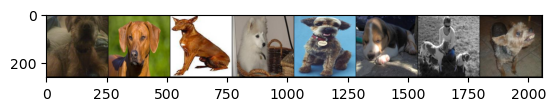

Shih-Tzu Border terrier Border terrier Golden retriever Shih-Tzu Samoyed Samoyed English foxhound


In [3]:
def show_samples(dataset, num_images):
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=num_images,
        shuffle=True, num_workers=2)
    
    dataiter = iter(loader)
    images, labels = next(dataiter)

    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(num_images)))


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


show_samples(train_dataset, 8)

In [4]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2
)

In [5]:
MAX_PARAMS = 3_000_000
MAX_EPOCHS = 50
LEARNING_RATE = 0.001
net = CNN()
assert net.num_of_params() <= MAX_PARAMS


In [6]:
from tqdm import tqdm, trange

def train_one_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim,
    data_loader: torch.utils.data.DataLoader,
    epoch_index: int,
    criterion: torch.nn.CrossEntropyLoss,
    device:str='cpu'  
):
    with tqdm(data_loader, unit='batch') as data:
        batch_loss_list = []
        for batch in data:
            data.set_description(f"Epoch {epoch_index}")

            # ? Feeding to CNN
            inputs, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            
            # ? Getting Loss
            batch_loss = criterion(outputs, labels)
            batch_loss_list.append(batch_loss.item())
            batch_loss.backward()

            # ? Gradient Descent
            optimizer.step()


            data.set_postfix(
                batch_loss=batch_loss.item()
            )

    
    return {
        'epoch_idx': epoch_index,
        'batch_losses': batch_loss_list,
        'epoch_loss': np.mean(batch_loss_list)
    }



def train(
    model: torch.nn.Module,
    optimizer: torch.optim,
    data_loader: torch.utils.data.DataLoader,
    epochs: int,
    criterion: torch.nn.CrossEntropyLoss,
    device:torch.device,
    writer: SummaryWriter
):

    

    model.train()

    epoch_statistics_list = []
    for epoch in range(epochs):
        epoch_statistics = train_one_epoch(
            model, optimizer, data_loader, epoch, criterion, device
        )
        
        epoch_statistics_list.append(epoch_statistics)
        writer.add_scalar('Loss/train', epoch_statistics['epoch_loss'], epoch)



    return epoch_statistics


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN()
model.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9) 
criterion = torch.nn.CrossEntropyLoss()
writer = SummaryWriter()
loss_statistics = train(model, optimizer, train_dataloader, MAX_EPOCHS, criterion, device, writer)
writer.flush()




  0%|          | 0/142 [00:00<?, ?batch/s]/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <063DD42B-A1DA-3BBE-AD5E-03C12F7E3DBA> /opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ai701/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ai701/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/ai701/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your e

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [26]:
batch_losses_0 = loss_statistics['batch_losses']
np.mean(batch_losses_0), loss_statistics['epoch_loss']

(2.295109272003174, 5.092273697257042)

In [14]:
shapes = set()
errors = []
images = glob.glob('data/imagewoof2-160/*/*/*.JPEG')
print(len(images))

for img_path in images:
    img = cv2.imread(img_path)
    try:
        shapes.add((img.shape))
    except AttributeError:
        errors.append(img_path)



# print(shapes)
heights_list = []
widths_list = []

for inst in shapes:
    h, w, _ = inst 
    heights_list.append(h)
    widths_list.append(w)

print(errors)


12954
[]


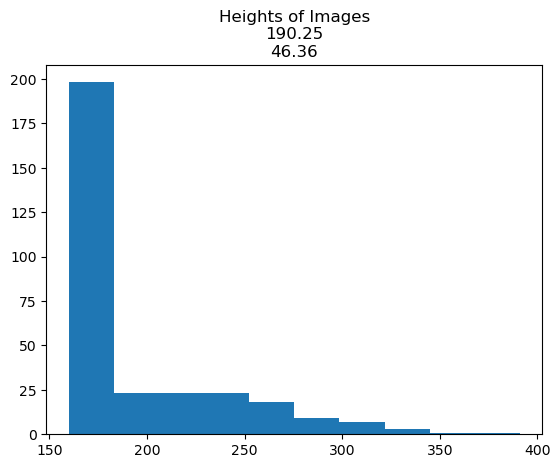

In [8]:
plt.hist(heights_list)
mean_h, std_h = np.mean(heights_list), np.std(heights_list)
plt.title(f'Heights of Images\n{mean_h:.2f}\n{std_h:.2f}')
plt.xlabel('')
plt.show()

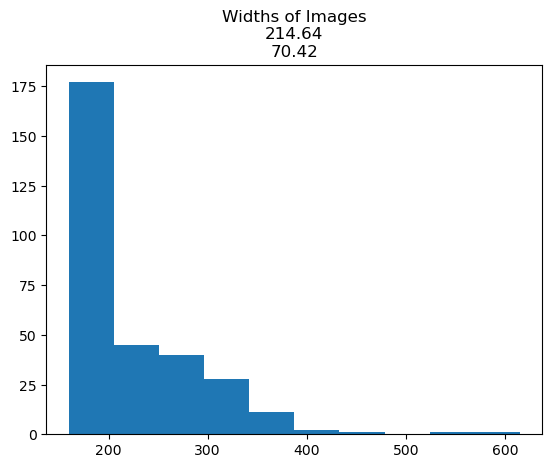

In [10]:
plt.hist(widths_list)
mean_w, std_w = np.mean(widths_list), np.std(widths_list)
plt.title(f'Widths of Images\n{mean_w:.2f}\n{std_w:.2f}')
plt.xlabel('')
plt.show()